In [139]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from tqdm import tqdm
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import vgg19, VGG19_Weights
import torch
import torch.nn as nn
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [118]:
DATA_DIR = "/kaggle/input/neural-style-transfer-imgs"

In [119]:
CONTENT_IMAGE = os.path.join(DATA_DIR , "mountains.jpeg")
STYLE_IMAGE = os.path.join(DATA_DIR , "van-gogh.jpg")

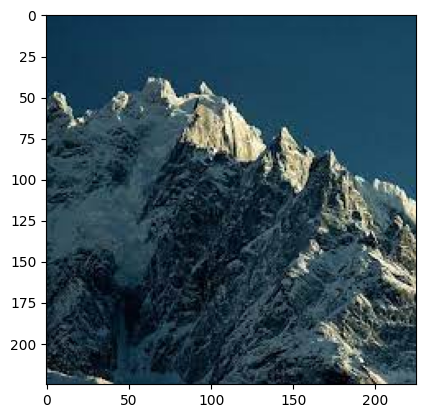

In [120]:
c_img = Image.open(CONTENT_IMAGE)
plt.imshow(c_img)

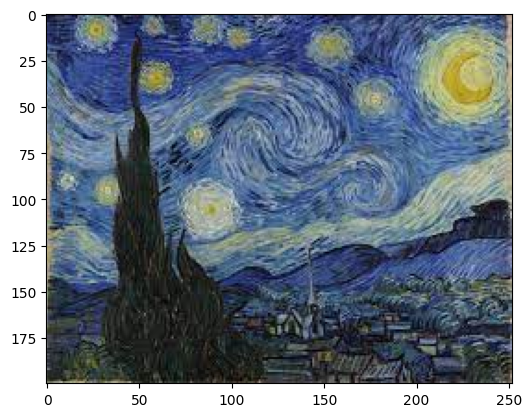

In [121]:
s_img = Image.open(STYLE_IMAGE)
plt.imshow(s_img)

# Content Representation

In [122]:
weights = VGG19_Weights.DEFAULT
model = vgg19(weights=weights)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [123]:
preprocess = weights.transforms()
batch = preprocess(c_img).unsqueeze(0)

# Keep only the first few layer

In [124]:
model = model.features[:17]

In [125]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

64


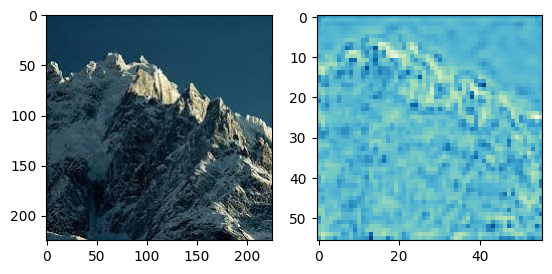

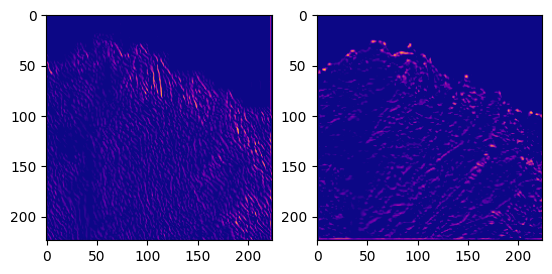

In [126]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model[2].register_forward_hook(get_activation('conv2'))

output = model(batch)

# Plot some images
idx = torch.randint(0, output.size(0), ())
pred = normalize_output(output[idx, 0])

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(c_img)
axarr[1].imshow(pred.detach().numpy(), cmap='GnBu')

act = activation['conv2'].squeeze()
print(act.size(0))
#print(act)
fig, axarr = plt.subplots(1, 2)
#for idx in range(act.size(0)):
axarr[0].imshow(act[16], cmap='plasma')
axarr[1].imshow(act[32], cmap='plasma')
#axarr[1].imshow(act[63], cmap='viridis')


In [127]:
def initialize_image_with_noise():
    noise = torch.randn(1, 3, 224, 224, requires_grad=True, device="cuda")
    return noise

In [128]:
noisy_img = initialize_image_with_noise()

In [129]:
#plt.imshow(noisy_img.detach().numpy(), cmap="gray")

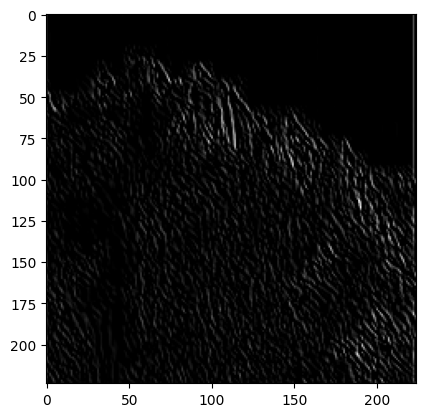

In [130]:
plt.imshow(act[16], cmap="gray")

In [131]:
content_img = activation['conv2']
content_img.ndim

4

In [132]:
batch.shape

torch.Size([1, 3, 224, 224])

In [133]:
loss_fn = nn.CrossEntropyLoss()
#params = list(model.parameters()) + list(noisy_img)
#parameters = list(model.parameters()) + [noisy_img]
optimizer = torch.optim.Adam([noisy_img], lr=0.01)

In [134]:
noisy_img.shape

torch.Size([1, 3, 224, 224])

In [135]:
def content_loss(content_image, noisy_image):
    # Extract the content features from both images
    #content_features = extract_content_features(content_image)
    #noisy_content_features = extract_content_features(noisy_image)

    # Compute the content loss
    content_loss = torch.mean(torch.pow(content_image - noisy_image, 2))

    return content_loss

In [136]:
def display_image(noisy_img):
    new_img = noisy_img.squeeze().cpu().detach()
    new_img = torch.permute(new_img, (1, 2, 0))
    plt.imshow(new_img)

  0%|          | 10/2500 [00:00<00:27, 90.17it/s]

Epoch:  1 Loss:  143.01792907714844


  5%|▍         | 116/2500 [00:01<00:33, 71.52it/s]

Epoch:  101 Loss:  21.799352645874023


  9%|▊         | 213/2500 [00:02<00:31, 72.77it/s]

Epoch:  201 Loss:  11.19225788116455


 12%|█▏        | 312/2500 [00:04<00:29, 74.31it/s]

Epoch:  301 Loss:  7.313562393188477


 17%|█▋        | 416/2500 [00:05<00:29, 71.65it/s]

Epoch:  401 Loss:  5.325033187866211


 21%|██        | 513/2500 [00:07<00:27, 72.78it/s]

Epoch:  501 Loss:  4.165252685546875


 24%|██▍       | 612/2500 [00:08<00:25, 74.34it/s]

Epoch:  601 Loss:  3.4069347381591797


 29%|██▊       | 716/2500 [00:09<00:24, 71.41it/s]

Epoch:  701 Loss:  2.8649282455444336


 33%|███▎      | 813/2500 [00:11<00:23, 72.78it/s]

Epoch:  801 Loss:  2.456347703933716


 36%|███▋      | 912/2500 [00:12<00:21, 74.25it/s]

Epoch:  901 Loss:  2.146043539047241


 41%|████      | 1016/2500 [00:14<00:20, 71.56it/s]

Epoch:  1001 Loss:  1.8960957527160645


 45%|████▍     | 1113/2500 [00:15<00:19, 72.76it/s]

Epoch:  1101 Loss:  1.6904841661453247


 48%|████▊     | 1212/2500 [00:16<00:17, 74.40it/s]

Epoch:  1201 Loss:  1.5197956562042236


 53%|█████▎    | 1316/2500 [00:18<00:16, 71.56it/s]

Epoch:  1301 Loss:  1.3776488304138184


 57%|█████▋    | 1413/2500 [00:19<00:14, 72.81it/s]

Epoch:  1401 Loss:  1.2560895681381226


 60%|██████    | 1512/2500 [00:21<00:13, 74.37it/s]

Epoch:  1501 Loss:  1.1519378423690796


 65%|██████▍   | 1616/2500 [00:22<00:12, 71.49it/s]

Epoch:  1601 Loss:  1.059531331062317


 69%|██████▊   | 1714/2500 [00:23<00:10, 72.88it/s]

Epoch:  1701 Loss:  0.9753763675689697


 73%|███████▎  | 1813/2500 [00:25<00:09, 73.78it/s]

Epoch:  1801 Loss:  0.8987230658531189


 76%|███████▋  | 1912/2500 [00:26<00:07, 74.25it/s]

Epoch:  1901 Loss:  0.8322205543518066


 81%|████████  | 2016/2500 [00:28<00:06, 71.48it/s]

Epoch:  2001 Loss:  0.7726611495018005


 85%|████████▍ | 2113/2500 [00:29<00:05, 72.79it/s]

Epoch:  2101 Loss:  0.7193184494972229


 88%|████████▊ | 2212/2500 [00:30<00:03, 74.30it/s]

Epoch:  2201 Loss:  0.668175220489502


 93%|█████████▎| 2316/2500 [00:32<00:02, 71.63it/s]

Epoch:  2301 Loss:  0.6247406005859375


 97%|█████████▋| 2413/2500 [00:33<00:01, 72.68it/s]

Epoch:  2401 Loss:  0.5817708373069763


100%|██████████| 2500/2500 [00:34<00:00, 71.87it/s]


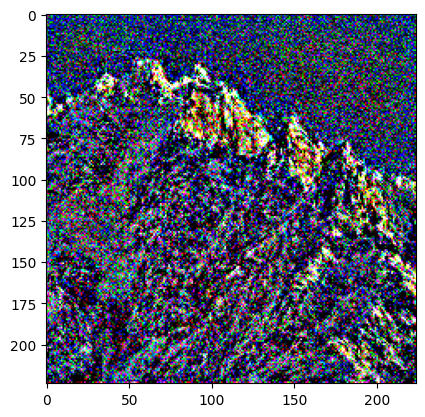

In [137]:
# Optimization loop
model.to("cuda")
#noisy_img = noisy_img.to("cuda")
batch = batch.to("cuda")
for i in tqdm(range(2500)):
    # Zero the gradients
    optimizer.zero_grad()
    #model.to("cuda")
    #noisy_img = noisy_img.to("cuda")
    #batch = batch.to("cuda")
    # Compute the loss
    output = model(noisy_img)
    content_img = model(batch)

    loss = content_loss(output, content_img)
    if i % 100 == 0:
        print("Epoch: ", i+1, "Loss: ", loss.item())
    
    # Backpropagation
    loss.backward()
    
    # Update the image
    optimizer.step()
    
    

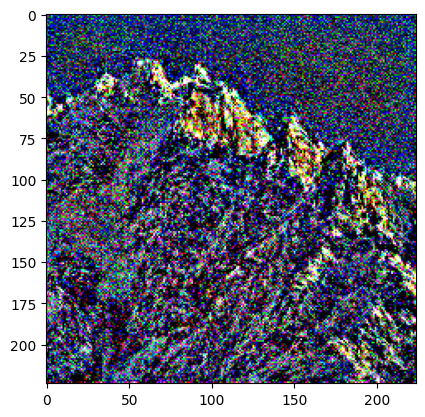

In [138]:
display_image(noisy_img)